# Link prediction for NetworKit

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [3]:
G = readGraph("input/CA-CondMat.edgelist", Format.SNAP)

In [4]:
partitionedGraph = linkprediction.RandomEdgePartitioner(G).partitionByPercentage(0.3)
G.numberOfEdges()

93497

In [5]:
partitionedGraph[0].numberOfEdges()

65448

In [6]:
partitionedGraph[1].numberOfEdges()

28049

In [7]:
katzIndex = linkprediction.KatzIndex(partitionedGraph[0], 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(partitionedGraph[0])
jaccardIndex = linkprediction.JaccardIndex(partitionedGraph[0])
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(partitionedGraph[0])
adamicAdarIndex = linkprediction.AdamicAdarIndex(partitionedGraph[0])

In [8]:
missingLinks = linkprediction.UnconnectedNodesFinder(partitionedGraph[0]).findAll(2)
len(missingLinks)

765255

In [9]:
#subset = missingLinks[:50000]

In [10]:
#dyadScorePairs = commonNeighborsIndex.runOnParallel(subset)
#samples = [x[0] for x in dyadScorePairs]
#features = [x[1] for x in dyadScorePairs]
#classes = []
#for p in samples:
#    classes.append(1 if partitionedGraph[1].hasEdge(p[0], p[1]) else 0)
#print("Positive / Negative =", sum(classes), "/", len(classes) - sum(classes))

In [11]:
#X = np.array(features)
#y = np.array(classes)

In [13]:
randomPos = partitionedGraph[1].randomEdges(25000)
randomNeg = []
ind = 0
while len(randomNeg) < 25000:
    if not partitionedGraph[1].hasEdge(missingLinks[ind][0], missingLinks[ind][1]):
        randomNeg.append(missingLinks[ind])
    ind += 1
merged = randomPos + randomNeg
random.shuffle(merged)
merged = np.array(merged)

dyadScorePairs = commonNeighborsIndex.runOnParallel(merged)
X1 = np.array([x[1] for x in dyadScorePairs])
dyadScorePairs = jaccardIndex.runOnParallel(merged)
X2 = np.array([x[1] for x in dyadScorePairs])
dyadScorePairs = commonNeighborsIndex.runOnParallel(merged)
X3 = np.array([x[1] for x in dyadScorePairs])
dyadScorePairs = adamicAdarIndex.runOnParallel(merged)
X4 = np.array([x[1] for x in dyadScorePairs])
r = np.column_stack((X1,X2,X3,X4))

classes = []
for p in dyadScorePairs:
    classes.append(1 if partitionedGraph[1].hasEdge(p[0][0], p[0][1]) else 0)
classes = np.array(classes)

classesTrain = classes[:40000]
classesTest = classes[-10000:]

featuresTrain = r[:40000]
featuresTest = r[-10000:]

nodePairsTrain = merged[:40000]
nodePairsTest = merged[-10000:]

In [14]:
featuresTrain.shape

(40000, 4)

In [15]:
dtc = tree.DecisionTreeClassifier()

In [16]:
dtc.fit(featuresTrain, classesTrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [17]:
#start_time = time.time()
#dyadScorePairs = katzIndex.runOnParallel(missingLinks)
#print("%s seconds" % (time.time() - start_time))

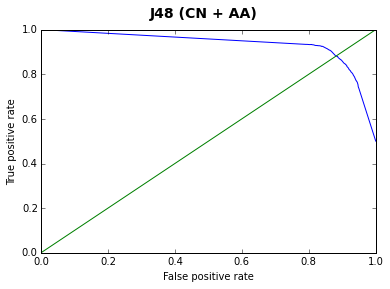

In [22]:
predictionsKNN = dtc.predict_proba(featuresTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
precision, recall, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(recall, precision)
plt.plot([0, 1], [0, 1])

In [20]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.92395285262302684

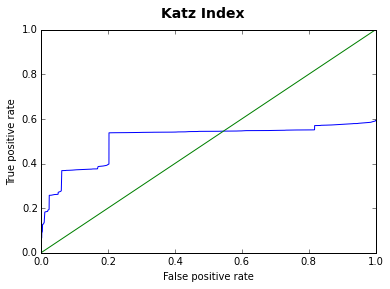

In [39]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [40]:
roc.areaUnderCurve()

0.5064284735999991

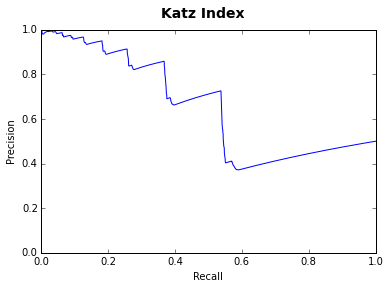

In [41]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [42]:
pr.areaUnderCurve()

0.6584974377255697

In [14]:
start_time = time.time()
dyadScorePairs = commonNeighborsIndex.runOnParallel(missingLinks)
dyadScorePairs = linkprediction.CommonNeighborsIndex.sortByScore(dyadScorePairs)
print("%s seconds" % (time.time() - start_time))

1.3254368305206299 seconds


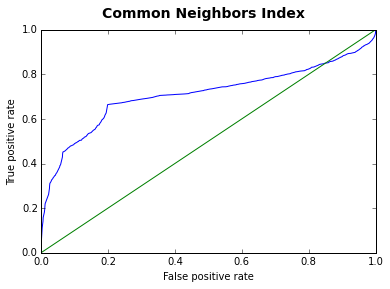

In [15]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [16]:
roc.areaUnderCurve()

0.7088040659471452

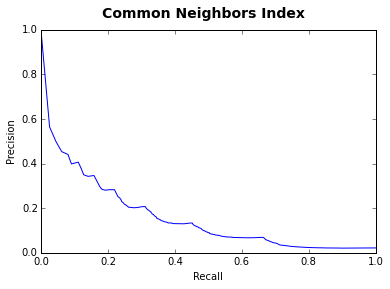

In [17]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [18]:
pr.areaUnderCurve()

0.1611081344700072

In [19]:
start_time = time.time()
dyadScorePairs = jaccardIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - start_time))

0.9683644771575928 seconds


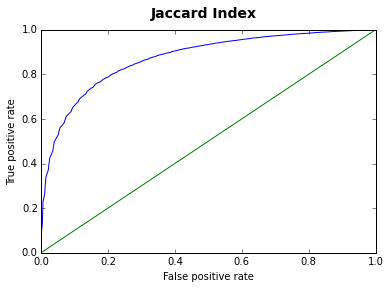

In [20]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [21]:
roc.areaUnderCurve()

0.8721625567575237

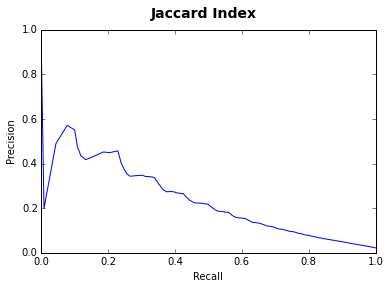

In [22]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [21]:
pr.areaUnderCurve()

0.2457082057711157

In [22]:
start_time = time.time()
dyadScorePairs = preferentialAttachmentIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - start_time))

0.47534990310668945 seconds


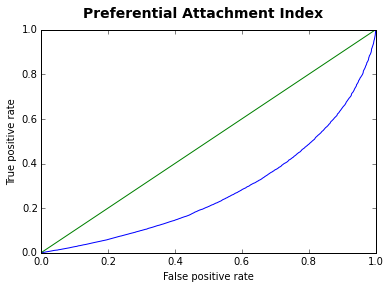

In [23]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [24]:
roc.areaUnderCurve()

0.2774959439332176

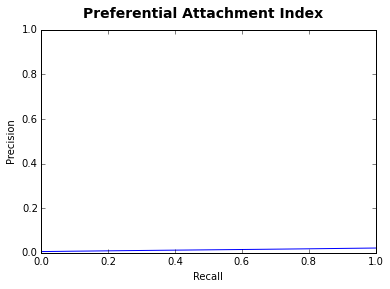

In [25]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [26]:
pr.areaUnderCurve()

0.013373871541683197

In [27]:
start_time = time.time()
dyadScorePairs = adamicAdarIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - start_time))

0.6599676609039307 seconds


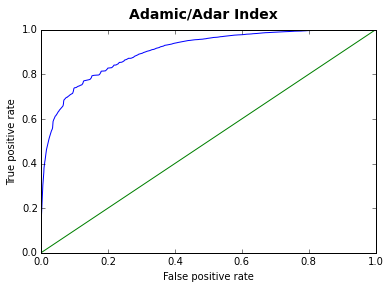

In [28]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [29]:
roc.areaUnderCurve()

0.9036966626566063

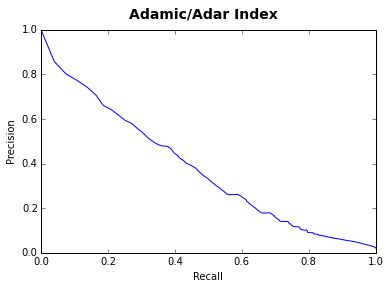

In [30]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [31]:
pr.areaUnderCurve()

0.37767454754774116

In [77]:
node = partitionedGraph[0].randomNode()
nodes = partitionedGraph[0].neighbors(node)

subGraph = graph.Subgraph().fromNodes(partitionedGraph[0], nodes)

In [78]:
LIST_LENGTH = len(nodes) - 1
a = []
color = {}
while len(a) < LIST_LENGTH:
    a.append(500)
for e in nodes:
    color[e] = len(nodes)
a.append(2000)
len(color)
color[list(color)[-1]] = len(nodes) / 2
color[list(color)[-2]] = len(nodes) / 3

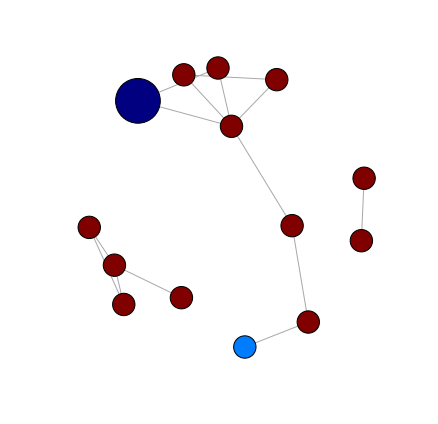

In [79]:
viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [ ]:
crossValidator = linkprediction.KFoldCrossValidator(G, commonNeighborsIndex, roc)
crossValidator.crossValidate(10)

Traceback (most recent call last):
  File "/home/xza/Thesis/NetworKit-Esders/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 3032, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/xza/Thesis/NetworKit-Esders/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 3032, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-a162fb8f0567>", line 2, in <module>
    crossValidator.crossValidate(10)
  File "_NetworKit.pyx", line 5561, in _NetworKit.KFoldCrossValidator.crossValidate (networkit/_NetworKit.cpp:45575)
MemoryError: std::bad_alloc

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xza/Thesis/NetworKit-Esders/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 1845, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'MemoryError' object has no attribute '_render_traceba

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.

